# Auditing Allocative Bias
---
title: Auditing Allocative Bias
author: Prateek Wadhavkar
---



# 1. Using folktables

In [3]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "AL"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,19,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
1,18,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,2,6.0
2,53,17.0,5,16,1,NaN,1,1.0,4.0,2,1,2,2,1.0,1,1,6.0
3,28,19.0,5,16,2,NaN,1,1.0,2.0,1,1,2,2,2.0,1,1,6.0
4,25,12.0,5,16,1,NaN,1,3.0,4.0,1,1,2,2,1.0,2,1,6.0


In [9]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

(47777, 15)
(47777,)
(47777,)


In [10]:
(y_hat == y_test).mean()
(y_hat == y_test)[group_test == 1].mean()
(y_hat == y_test)[group_test == 2].mean()

0.7838630806845965

# 2 Basic Descriptives

I will predict whether income is over $50K on the basis of demographics excluding sex, and audit for gender bias in Utah

I will use logistic regression from sklearn.linear_model.LogisticRegression

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter



STATE = "UT"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
predictor='PINCP' #household income

UT_data= acs_data[[*possible_features, predictor]].copy()

acs_data[possible_features].head()



#df = pd.DataFrame(X_train, columns = features_to_use)
#df["group"] = group_train
#df["label"] = y_train

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,78,22.0,3,16,1,NaN,1,3.0,4.0,4,1,2,1,2.0,2,1,6.0
1,36,19.0,3,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,1,6.0
2,15,11.0,5,16,1,NaN,4,3.0,NaN,1,2,2,2,1.0,1,6,NaN
3,67,16.0,3,16,1,NaN,1,3.0,4.0,2,1,2,2,2.0,2,1,6.0
4,21,18.0,5,17,2,NaN,1,2.0,4.0,1,1,2,2,2.0,2,1,3.0


1) How many individuals are in the data?
    

In [3]:
n= UT_data.shape[0]
print("This dataset has "+str(n)+" individuals")

This dataset has 31603 individuals


2) Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.
    

In [4]:
n_50k=UT_data[UT_data["PINCP"] > 50000].shape[0]

print("Out of the "+str(n)+" individuals in this dataset, "+str(n_50k)+" individuals make more than $50,000")

print("This means that "+str(n_50k*100/n)+"% of the population of Utah earns over 50k")

Out of the 31603 individuals in this dataset, 6088 individuals make more than $50,000
This means that 19.26399392462741% of the population of Utah earns over 50k


3) Of these individuals, how many are in each of the groups?
    
4) In each group, what proportion of individuals have target label equal to 1?


In [5]:
n_female_50k= UT_data[(UT_data["PINCP"] > 50000) & (UT_data["SEX"]==2)].shape[0]
n_male_50k= n_50k- n_female_50k
n_female=UT_data[(UT_data["SEX"]==2)].shape[0]
n_male= n-n_female

print("This sample contains "+str(n_male)+" men and "+str(n_female)+" women. This means that this sample is "+str(n_female*100/n)+" female")
print("Out of the "+str(n_male)+ " men, "+str(n_male_50k)+" earn over 50k. This corresponds to "+str(n_male_50k*100/n_male)+"% of all men")
print("Out of the "+str(n_female)+ " women, "+str(n_female_50k)+" earn over 50k. This corresponds to "+str(n_female_50k*100/n_female)+"% of all women")
print("Out of the "+str(n_50k)+" people earning over 50k, only "+str(n_female_50k)+" or "+str(n_female_50k*100/n_50k)+"% are women")



This sample contains 15707 men and 15896 women. This means that this sample is 50.2990222447236 female
Out of the 15707 men, 4515 earn over 50k. This corresponds to 28.745145476539122% of all men
Out of the 15896 women, 1573 earn over 50k. This corresponds to 9.895571212883745% of all women
Out of the 6088 people earning over 50k, only 1573 or 25.8377135348226% are women


5) Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group labe. For example, if you chose race (RAC1P) as your group, then you could also choose sex (SEX) and compute the proportion of positive labels by both race and sex. This might be a good opportunity to use a visualization such as a bar chart, e.g. via the seaborn package.

Let us observe how this breakdown differs on the basis of race.

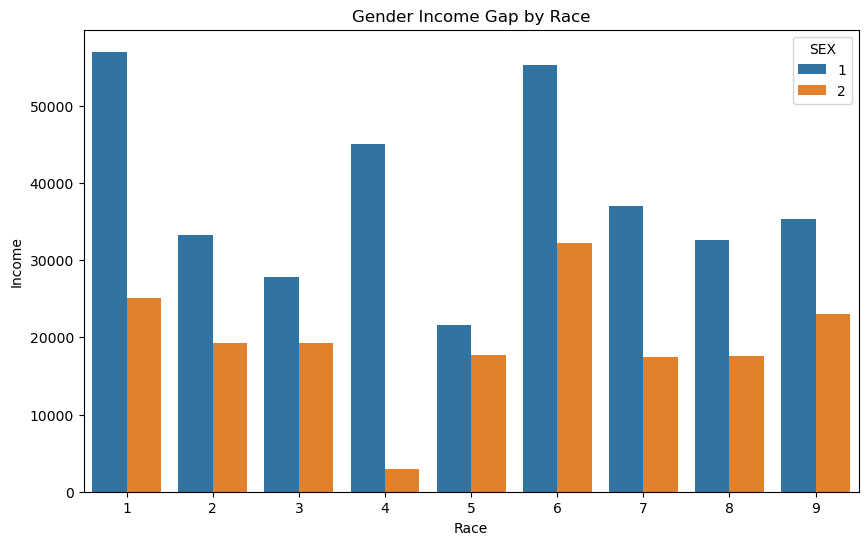

In [6]:
grouped_data = UT_data.groupby(['RAC1P', 'SEX']).mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='RAC1P', y='PINCP', hue='SEX', data=grouped_data)
plt.title('Gender Income Gap by Race')
plt.xlabel('Race')
plt.ylabel('Income')
plt.show()


This chart shows that all races observe a gender income gap. However, races 1 and 4 have an extremely high income gap. Let us break it down by the proportion of each race making more than 50k.

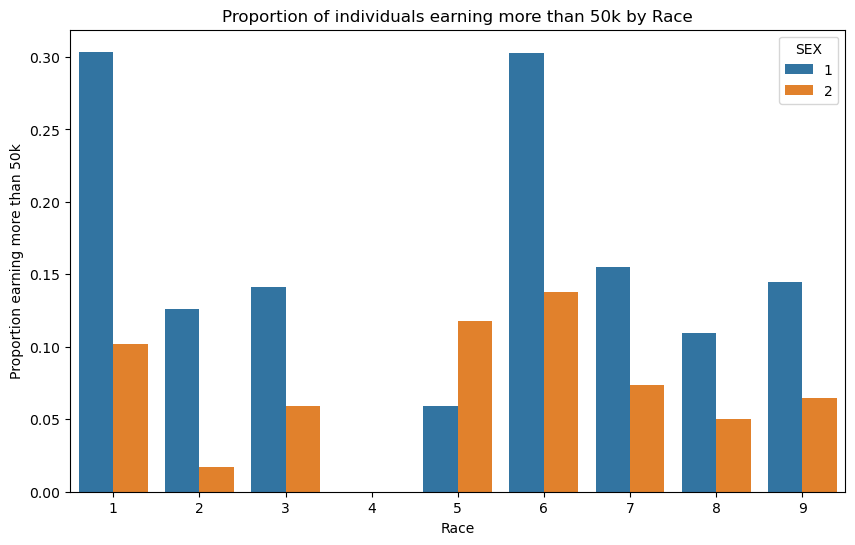

In [7]:
#grouped_data2 = UT_data.groupby(['RAC1P', 'SEX'])['PINCP'].apply(lambda x: (x == '>50k').mean().reset_index()

grouped_data2 = UT_data.groupby(['RAC1P', 'SEX'])['PINCP'].apply(lambda x: (x > 50000).mean()).reset_index()                                                           
                                                                  
plt.figure(figsize=(10, 6))
sns.barplot(x='RAC1P', y='PINCP', hue='SEX', data=grouped_data2)
plt.title('Proportion of individuals earning more than 50k by Race')
plt.xlabel('Race')
plt.ylabel('Proportion earning more than 50k')
plt.show()


This breakdown appears to be even starker for races 1, 2 and 3. 
We observe 0 individuals from race 4 making over 50k.

# Train Your Model

Let us now construct a BasicProblem.

In [8]:
features_to_use = [f for f in possible_features if f not in ["SEX"]]


GenderPayProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = GenderPayProblem.df_to_numpy(UT_data)

In [9]:
for obj in [features, label, group]:
  print(obj.shape)

(31603, 16)
(31603,)
(31603,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), 
                      PolynomialFeatures(degree=3), 
                      LogisticRegression())
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
(y_hat == y_test).mean()


/Users/prateekwadhavkar/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8286663502610346

# Audit Your Model

## Overall Measures

    What is the overall accuracy of your model?
    What is the positive predictive value (PPV) of your model?
    What are the overall false negative and false positive rates (FNR and FPR) for your model?

In [20]:
from sklearn.metrics import confusion_matrix


y_hat = model.predict(X_test)
overall_accuracy=(y_hat == y_test).mean()

print("the overall accuracy of this model is "+str(overall_accuracy*100)+"%")

### What are the overall false negative and false positive rates (FNR and FPR) for your model?
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

ppv= tp/(fp+tp)
print("the PPV of my model is "+str(ppv))

fnr=fn / (fn + tp)
fpr=fp / (fp + tn)

print("the FNR of my model is "+str(fnr))
print("the FPR of my model is "+str(fpr))


the overall accuracy of this model is 82.86663502610347%
the PPV of my model is 0.5755968169761273
the FNR of my model is 0.48086124401913877
the FPR of my model is 0.09473060982830077


Our model appears to have a fairly high accuracy. However, as we can observe, the PPV for our model is actually low, and the FNR is quite high. The PPV predicts the probability of a value we predict to be positive actually being positive. FNR represents the proportion of false negatives out of all the individuals who truly have a positive outcome. 

## By-Group Measures

    What is the accuracy of your model on each subgroup?
    What is the PPV of your model on each subgroup?
    What are the FNR and FPR on each subgroup?

Let us now divide our data based on sex, and assess the accuracy, FNR, PPV and FPR for both sexes



In [32]:
accuracy_men=(y_hat == y_test)[group_test == 1].mean()
accuracy_women=(y_hat == y_test)[group_test == 2].mean()

print("the accuracy for men is "+str(accuracy_men))
print("the accuracy for women is "+str(accuracy_women))

tn_w, fp_w, fn_w, tp_w = confusion_matrix(y_test[group_test == 2], model.predict(X_test[group_test == 2])).ravel()
#tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

ppv_w=tp_w /(fp_w + tp_w)
fnr_w=fn_w / (fn_w + tp_w)
fpr_w=fp_w / (fp_w + tn_w)

print("the PPV for women is "+str(ppv_w))
print("the FNR for women is "+str(fnr_w))
print("the FPR for women is "+str(fpr_w))

tn_m, fp_m, fn_m, tp_m = confusion_matrix(y_test[group_test == 1], model.predict(X_test[group_test == 1])).ravel()


ppv_m=tp_m /(fp_m + tp_m)
fnr_m=fn_m / (fn_m + tp_m)
fpr_m=fp_m / (fp_m + tn_m)

print("the PPV for men is "+str(ppv_m))
print("the FNR for men is "+str(fnr_m))
print("the FPR for men is "+str(fpr_m))


the accuracy for men is 0.806472284524191
the accuracy for women is 0.8503125
the PPV for women is 0.3304157549234136
the FNR for women is 0.5339506172839507
the FPR for women is 0.10639777468706536
the PPV for men is 0.7418397626112759
the FNR for men is 0.46236559139784944
the FPR for men is 0.07941579187585578


we can observe the following:

    Accuracy: Women have a slightly higher accuracy than men.
    PPV: Men have a significantly higher PPV compared to women, indicating that when men are predicted as positive, they are more likely to truly have the positive outcome.
    FNR: Women have a higher FNR than men, suggesting that women are more likely to be falsely classified as negative (not having the positive outcome) when they actually have it.
    FPR: Women have a higher FPR than men, indicating that women are more likely to be falsely classified as positive (having the positive outcome) when they don't actually have it.
    
## Bias Measures

See Chouldechova (2017) for definitions of these terms. For calibration, you can think of the score as having only two values, 0 and 1.

    Is your model approximately calibrated?
    Does your model satisfy approximate error rate balance?
    Does your model satisfy statistical parity?
   

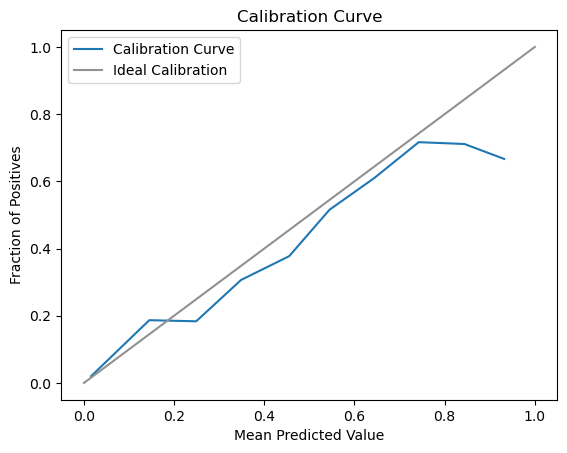

In [45]:
from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, label='Calibration Curve')
plt.plot([0, 1], [0, 1], color="#919191", label='Ideal Calibration')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

Our calibration curve appears to be somewhat in line with the ideal calibration line until the 0.75 mean predicted value. However, following this predicted value, it appears as though our model is underconfident. This means that the predicted probabilities are generally lower than the observed probabilities. In other words, the model is less certain about positive instances than it should be.


In [46]:
ppv_gap=ppv_w-ppv_m
fnr_gap=fnr_w-fnr_m
fpr_gap=fpr_w-fpr_m

print("ppv_gap= "+str(ppv_gap)+" fnr_gap="+str(fnr_gap)+" fpr_gap="+str(fpr_w))


ppv_gap= -0.41142400768786236 fnr_gap=0.07158502588610122 fpr_gap=0.10639777468706536


We do not observe a high level of difference for the false negative and positive rates, suggesting that our model satisfies approximate error rate balance. However, the false negative and positive rates are both higher for women.

# Concluding paragraphs

What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial use?

This tool could be very useful for policymakers studying ways to alleviate the income gap. This model is also useful for credit agencies and insurance companies in determining the risk of insuring or giving credit to an individual.

Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?

The false negative and positive rates are both higher for women compared to men. This means that women are more likely to be misclassified by our model- which indicates that 

Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?

The calibration rate suggests that our model is somewhat underconfident. The model has a higher PPV for men (74.18%) compared to women (33.04%), indicating that when the model predicts a positive outcome, it is more likely to be correct for men than for women. The FNR is higher for women (53.40%) compared to men (46.24%), suggesting that the model is more likely to miss positive outcomes for women compared to men. False Positive Rate (FPR): The FPR is slightly higher for women (10.64%) compared to men (7.94%), indicating that the model is more likely to wrongly predict positive outcomes for women than for men.

The large gap in PPV is most concerning for me.
